# Implementation of a flow through a porous medium
modified by Javier E. Santos


Description: This notebook calculates the steady-state single-phase laminar flow and the permeability of a domain with overlapping spheres

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import lettuce as lt

## Define Flow and Boundary Condition

In [2]:
class PeriodicPressureBC:
    """According to Ehsan Evati: 'High performance simulation of fluid flow in porous media...' 
    """
    def __init__(self, flow: 'Flow', delta_rho: float):
        self.flow   = flow
        self.delta_rho = delta_rho
        
    def __call__(self, f):
        f[[1,5,8], 0,:] = (f[[1,5,8], 0,:]
                           + self.flow.stencil.w[[1,5,8], None]
                           * self.delta_rho)
        f[[3,6,7],-1,:] = (f[[3,6,7],-1,:]
                           - self.flow.stencil.w[[3,6,7],None]
                           * self.delta_rho)
        return f

In [3]:
class PorousMedium2D(lt.Obstacle):
    def __init__(
            self,
            context: 'Context',
            resolution_x: int,
            resolution_y: int,
            Ma: float,
            pressure_difference: float,
            stencil: 'Stencil'
    ):
        self.stencil = stencil
        u_lbm = self.stencil.cs*Ma
        omega = 1.0
        self.nu = (1/omega - 0.5)/(1/self.stencil.cs)**2
        Re    = u_lbm*nx/self.nu
        super().__init__(
            context=context,
            resolution=[resolution_x, resolution_y],
            reynolds_number=Re,
            mach_number=Ma,
            domain_length_x=1,
            stencil=stencil
        )
        self.delta_rho = pressure_difference
    
    @property
    def boundaries(self):
        return [
            # left/right
            PeriodicPressureBC(self, self.delta_rho),
            # bounce back periodic medium
            lt.BounceBackBoundary(self.mask)
            # periodic in y direction
        ]

## Setting up domain and flow parameters

In [4]:
# user-defined parameters

nx = 512 # domain length in x-dir
ny = 512 # domain length in y-dir

n_buffer = 10 # number of buffer layers
it_check = 100 # check for convergence every n-iterations 
it_max   = 1e7 # break after max its its reached
epsilon  = 0.1 # break after the diff between its it's less than e %

delta_rho_lu = 0.005 # my code uses 0.0005
resolution   = 1e-6 # [lu/pu] microns

device = 'cuda:0' # gpu
dtype  = torch.float64 # torch types: torch.float64 is stable and accurate

In [5]:
context = lt.Context(torch.device(device), dtype)
Ma    = 0.01 # I set this arbitrarily
flow = PorousMedium2D(
    context=context, resolution_x=nx, resolution_y=ny, Ma=Ma, 
    pressure_difference=delta_rho_lu, stencil=lt.D2Q9()
)

In [6]:
# make porous medium by inserting random circles
np.random.seed(234269)
n_circles = 125
for i in range(n_circles):
    x, y = flow.grid
    x0 = np.random.rand()
    y0 = np.random.rand()*y.max()
    r = 0.02 + 0.02 * np.random.rand()
    circle = ((x-x0)**2 + (y-y0)**2 < r**2)
    flow.mask[circle] = 1

# make a buffer region that should have constant pressure
flow.mask[ :n_buffer, :] = 0
flow.mask[-n_buffer:, :] = 0

# calculate porosity
phi = 1-torch.sum(flow.mask).item()/(nx*ny)

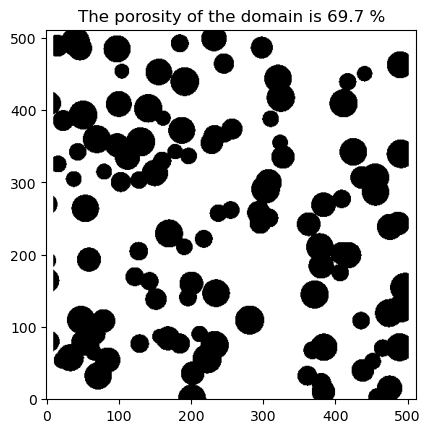

In [7]:
plt.imshow(flow.mask.cpu().numpy().transpose(), origin="lower", cmap='gray_r')
plt.title(f'The porosity of the domain is {phi*100:2.1f} %');

## Run Simulation

In [8]:
collision  = lt.BGKCollision(tau=flow.units.relaxation_parameter_lu)
simulation = lt.Simulation(flow=flow, collision=collision)

Could not resolve native extension.
Installing Native module (/tmp/tmp7ap3r94p) ...


In [9]:
u_t = [np.inf] # save it info for plotting
for i in range(1,int(it_max//it_check)):   
    simulation(it_check)
    u_t.append(flow.u_pu.mean()) 
    rel_change = ((u_t[-1]-u_t[-2])/u_t[-1]*100).abs() 
    print(f'it {i*it_check} {u_t[-1]} the relative change in mean vel is {rel_change} %')
    if rel_change < epsilon:
        break

it 100 1.6666666666666793e-05 the relative change in mean vel is inf %
it 200 1.6666666666666793e-05 the relative change in mean vel is 0.0 %


Text(0, 0.5, 'mean log10(|velocity|) [lus]')

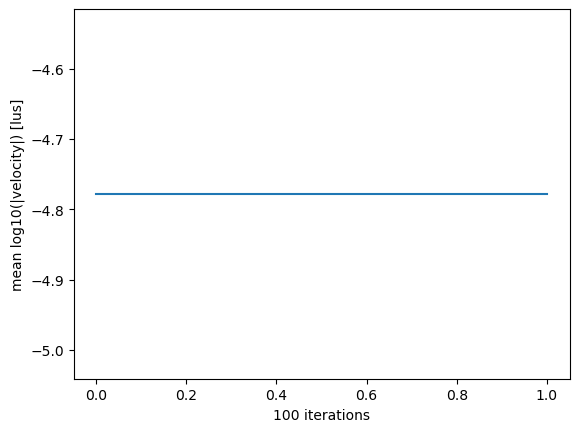

In [10]:
u_t = [x.cpu().numpy() for x in u_t[1:]]
plt.plot(np.log10(np.abs(u_t)))
plt.xlabel(f'{it_check} iterations')
plt.ylabel(f'mean log10(|velocity|) [lus]')

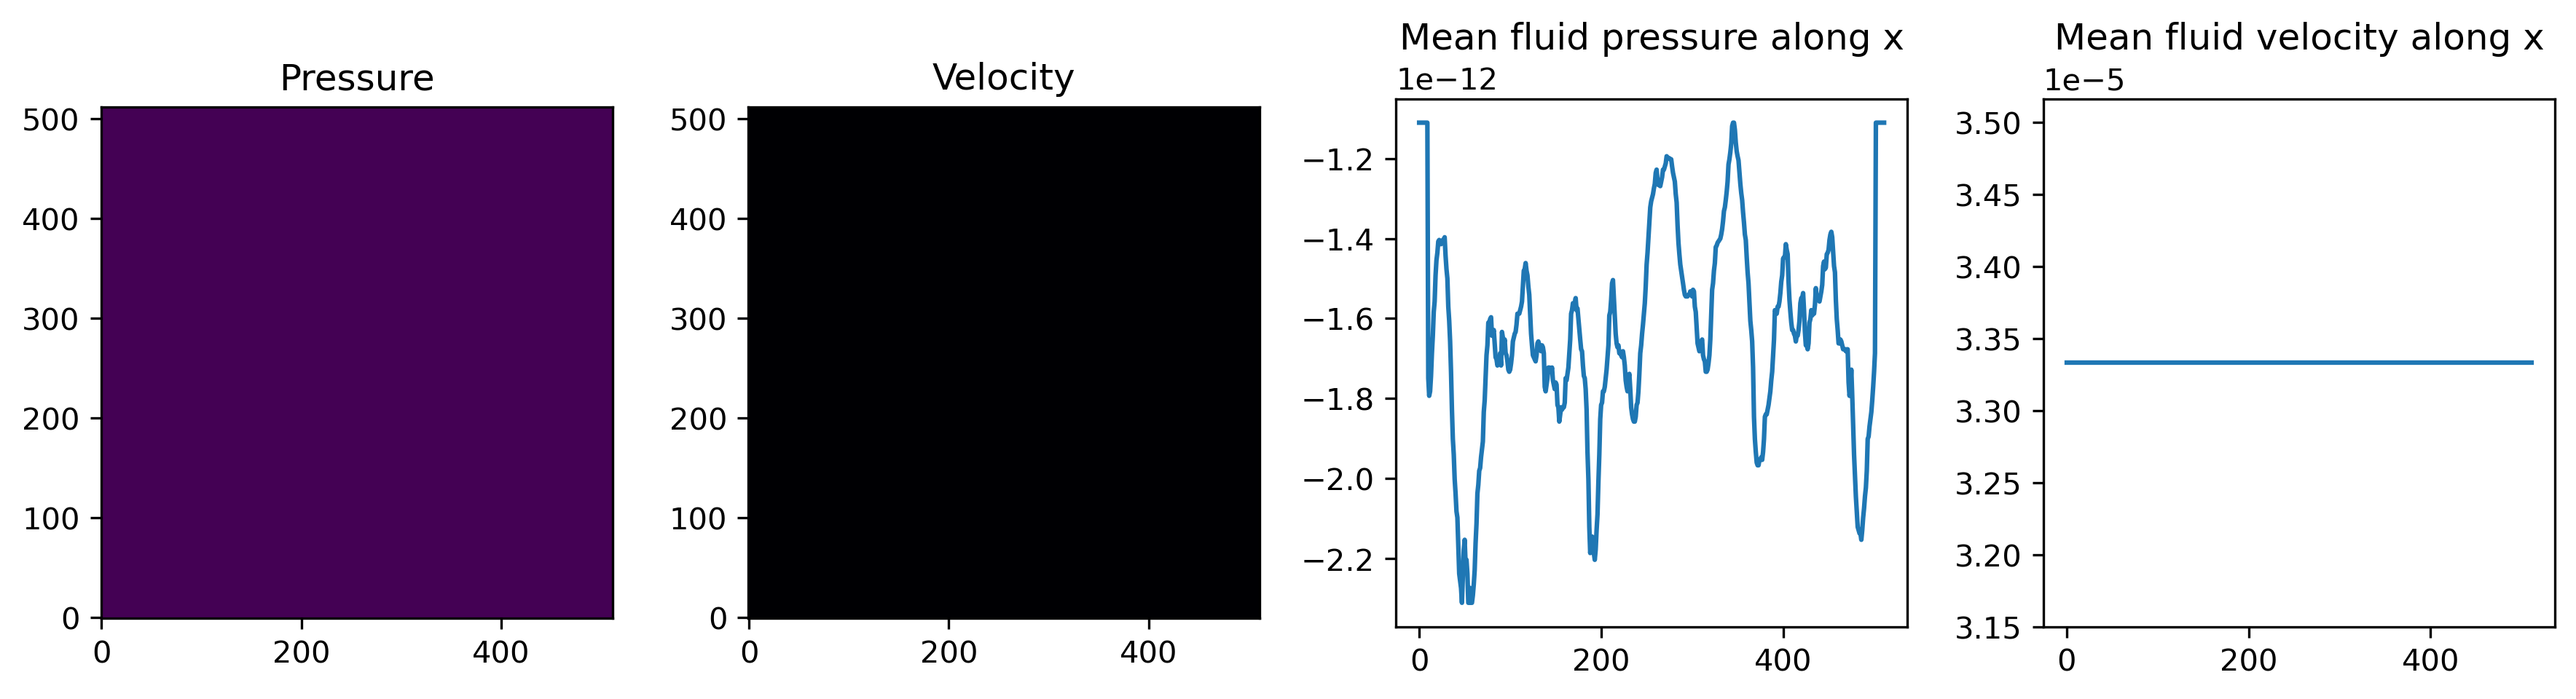

In [11]:
u = flow.u_pu
k = flow.nu*u.mean()/(delta_rho_lu/nx)*resolution**2
rho = flow.rho()
u = u.cpu().numpy()
p = flow.p_pu.cpu().detach().numpy()
unorm = np.linalg.norm(u, axis=0)

# Plot without outliers due to bounce-back contacts
fig, axes = plt.subplots(1,4, figsize=(12,3), dpi=300)
fig.tight_layout()
axes[0].set_title("Pressure")
axes[0].imshow(p[0].transpose(), origin="lower", )#vmin=p[0,ny-1,0], vmax=p[0].mean(axis=-1).max())
axes[1].set_title("Velocity")
axes[1].imshow(unorm.transpose(), origin="lower", cmap='inferno',
               vmin=np.percentile(unorm.flatten(),1),
               vmax=np.percentile(unorm.flatten(),95)
              )
axes[2].set_title("Mean fluid pressure along x")
axes[2].plot(p[0].sum(axis=-1)/(~flow.mask).sum(axis=-1))
axes[3].set_title("Mean fluid velocity along x")
axes[3].plot(u[0].mean(axis=-1));


In [12]:
print(f'Porosity = {phi*100:.4f} % and Permeability = {k:.4e} [m^2]')

Porosity = 69.7376 % and Permeability = 2.8444e-13 [m^2]
